# **HW 3: Data Clustering**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Athimet Aiewcharoen 63340500068
<hr>

In [33]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)

In [34]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

In [35]:
def KMeansModelGenerator(dataFrame, target ,k):
  df = dataFrame.copy()
  kmeans_clf = KMeans(n_clusters=k, random_state=1,)
  kmeans_clf = kmeans_clf.fit(df.drop(target, axis=1))
  labels = kmeans_clf.labels_
  df['cluster'] = labels
  silhouetteScore = silhouette_score(df.drop([target], axis=1), labels, metric='euclidean', random_state=1)
  print('Silhouette score: ', silhouetteScore)
  print('WCSS: ', kmeans_clf.inertia_)
  # randScore = rand_score(df[target], labels)
  # print('Rand score: ', randScore)
  print('Model Centroids: \n', kmeans_clf.cluster_centers_)
  for idx,var in enumerate(df[target].unique()):
    print('Target class (',target,f'[{var}])', 'Size: ', df[df[target] == var].shape[0])
  for idx,var in enumerate(df['cluster'].unique()):
    print('Cluster (',var,')', 'Size: ', df[df['cluster'] == var].shape[0])
  return kmeans_clf , df

In [36]:
def checkCorrFF(df, pathToImg = None):
    plt.figure(figsize=(20,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap='inferno')
    if pathToImg != None:
        plt.savefig(pathToImg, bbox_inches='tight')
    plt.show()

## **Data Exploration**

From the description file, there are a total of 17 features in this dataset which are:

|Feature Name|Description|Data Type|
|:-:|-|:-:|
|<font color='green'>age</font>|Customer's age (in years)|<font color='red'>Numerical</font>|
|<font color='green'>job</font>|Types of Job|<font color='red'>Categorical</font>|
|<font color='green'>marital</font>|Marital Status|<font color='red'>Categorical</font>|
|<font color='green'>education</font>|Education|<font color='red'>Categorical</font>|
|<font color='green'>default</font>|Has credit in Default?|<font color='red'>Categorical</font>|
|<font color='green'>balance</font>|Average yearly balance|<font color='red'>Numerical</font>|
|<font color='green'>housing</font>|Has housing loan?|<font color='red'>Categorical</font>|
|<font color='green'>loan</font>|Has personal loan?|<font color='red'>Categorical</font>|
|<font color='green'>contact</font>|Contact Communication Type|<font color='red'>Categorical</font>|
|<font color='green'>day</font>|Last contact day of the month|<font color='red'>Numerical</font>|
|<font color='green'>month</font>|Last contact month of the year|<font color='red'>Categorical</font>|
|<font color='green'>duration</font>|Last contact duration (in seconds).<br><br> Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.|<font color='red'>Numerical</font>|
|<font color='green'>campaign</font>|no. of contacts performed during this campaign and for this client|<font color='red'>Numerical</font>|
|<font color='green'>pdays</font>|no. of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted)|<font color='red'>Numerical</font>|
|<font color='green'>previous</font>|no. of contacts performed before this campaign and for this client|<font color='red'>Numerical</font>|
|<font color='green'>poutcome</font>|outcome of the previous marketing campaign|<font color='red'>Categorical</font>|
|<font color='green'>y</font>|has the client subscribed a term deposit?|<font color='red'>Categorical</font> [Output]|

Number of instances: 45211 for bank-full.csv <br>
Number of Attributes: 16 + output attribute (17)<br>
(45211 rows, 17 columns)

Missing Attribute Values: None

### **Import Dataset**

In [37]:
dfOri = pd.read_csv('../HWdata/bank/bank-full.csv', sep=';')
df = dfOri.copy()

In [38]:
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [39]:
df.tail()

age           job   marital  education default  balance housing loan  \
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45207   cellular   17   nov       456         2     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no

In [40]:
print(f"No. of Instances: {df.shape[0]}\nNo. of Features: {df.shape[1]}")

No. of Instances: 45211
No. of Features: 17


### **Remove Unnecessary Features**

In [41]:
if 'duration' in df.columns:
    df.drop('duration', axis=1, inplace=True)
    print(f"No. of Features Left: {df.shape[1]}")
else:
    print("\'Duration\' removed!")

No. of Features Left: 16


### **Check and Remove Duplicates** 

In [42]:
print(f"No. of Duplicates: {df.duplicated().sum()}")

No. of Duplicates: 16


In [43]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No duplicates!")

No. of Instances Left: 45195


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45195 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45195 non-null  int64 
 1   job        45195 non-null  object
 2   marital    45195 non-null  object
 3   education  45195 non-null  object
 4   default    45195 non-null  object
 5   balance    45195 non-null  int64 
 6   housing    45195 non-null  object
 7   loan       45195 non-null  object
 8   contact    45195 non-null  object
 9   day        45195 non-null  int64 
 10  month      45195 non-null  object
 11  campaign   45195 non-null  int64 
 12  pdays      45195 non-null  int64 
 13  previous   45195 non-null  int64 
 14  poutcome   45195 non-null  object
 15  y          45195 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.9+ MB


### **Check and Remove Missing Values**

In [45]:
if df.isna().sum().sum() > 0:
    df.dropna(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No missing values!")

No missing values!


### **Replace Data in "pdays"**
The datasets stated that the value of -1 in "pdays" means that the client was not previously contacted. However, the value of -1 is not a valid value for "pdays" because it is a numerical value (day can't be negative). Therefore, we replace the value of -1 with 0.

In [46]:
df['pdays'].value_counts()

-1      36938
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: pdays, Length: 559, dtype: int64

In [47]:
df['pdays'].replace(-1, 0, inplace=True)
df['pdays'].value_counts()

0      36938
182      167
92       147
91       126
183      126
       ...  
449        1
452        1
648        1
595        1
530        1
Name: pdays, Length: 559, dtype: int64

Since there are 16 duplicated instances and no missing values, we are left with 45195 instances.  
Furthermore, after dropping the unnecessary features, we are left with 16 features including output (y).

In which, there are:

- 10 features, including output, that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 6 features that are '<font color='green'>int64</font>', which means that they are '<font color='red'>Numerical Features</font>'

### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features
3. Output

**Separate Numerical Features from Dataset**

In [48]:
dfNum = df.select_dtypes(include=['int64'])

**Separate Categorical Features from Dataset**

In [49]:
dfCate = df.select_dtypes(include=['object'])
dfCate = dfCate.iloc[:,:-1]

**Separate Output from Dataset**

In [50]:
dfOut = df.iloc[:,len(df.columns)-1:len(df.columns)]

**Concatenate Separated Data**

In [51]:
df = pd.concat([dfNum, dfCate, dfOut], axis=1)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

**Separate Yes and No from Output**

In [52]:
dfYes = df[df['y'] == 1]
dfNo = df[df['y'] == 0]

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45195 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45195 non-null  int64 
 1   balance    45195 non-null  int64 
 2   day        45195 non-null  int64 
 3   campaign   45195 non-null  int64 
 4   pdays      45195 non-null  int64 
 5   previous   45195 non-null  int64 
 6   job        45195 non-null  object
 7   marital    45195 non-null  object
 8   education  45195 non-null  object
 9   default    45195 non-null  object
 10  housing    45195 non-null  object
 11  loan       45195 non-null  object
 12  contact    45195 non-null  object
 13  month      45195 non-null  object
 14  poutcome   45195 non-null  object
 15  y          45195 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 5.9+ MB


### **Overall Report**

In [54]:
dfProfile = df.copy()
dfProfile.reset_index(drop=True, inplace=True)
profile = pp.ProfileReport(dfProfile, title="Bank Full Report", dark_mode=True)
profile.config.html.style.primary_color = '#3CA2D3'
if not os.path.exists(os.path.join(currDir, 'HW3OverallReport.html')):
    profile.to_file('HW3OverallReport.html')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Plot Features of Separated Output**

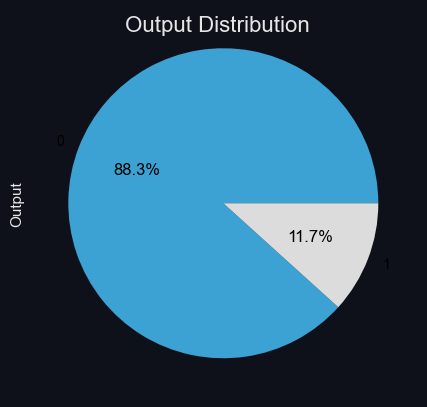

In [55]:
OutDist, ax = plt.subplots(1, 1, figsize=(5,5))
df.groupby('y').size().plot(kind = 'pie',
                            y = "y",
                            autopct = '%1.1f%%',
                            ax = ax,
                            colormap = cmap)
ax.set_ylabel('Output')
OutDist.suptitle("Output Distribution", fontsize=16, color=titleColor)
OutDist.subplots_adjust(top=1.1)

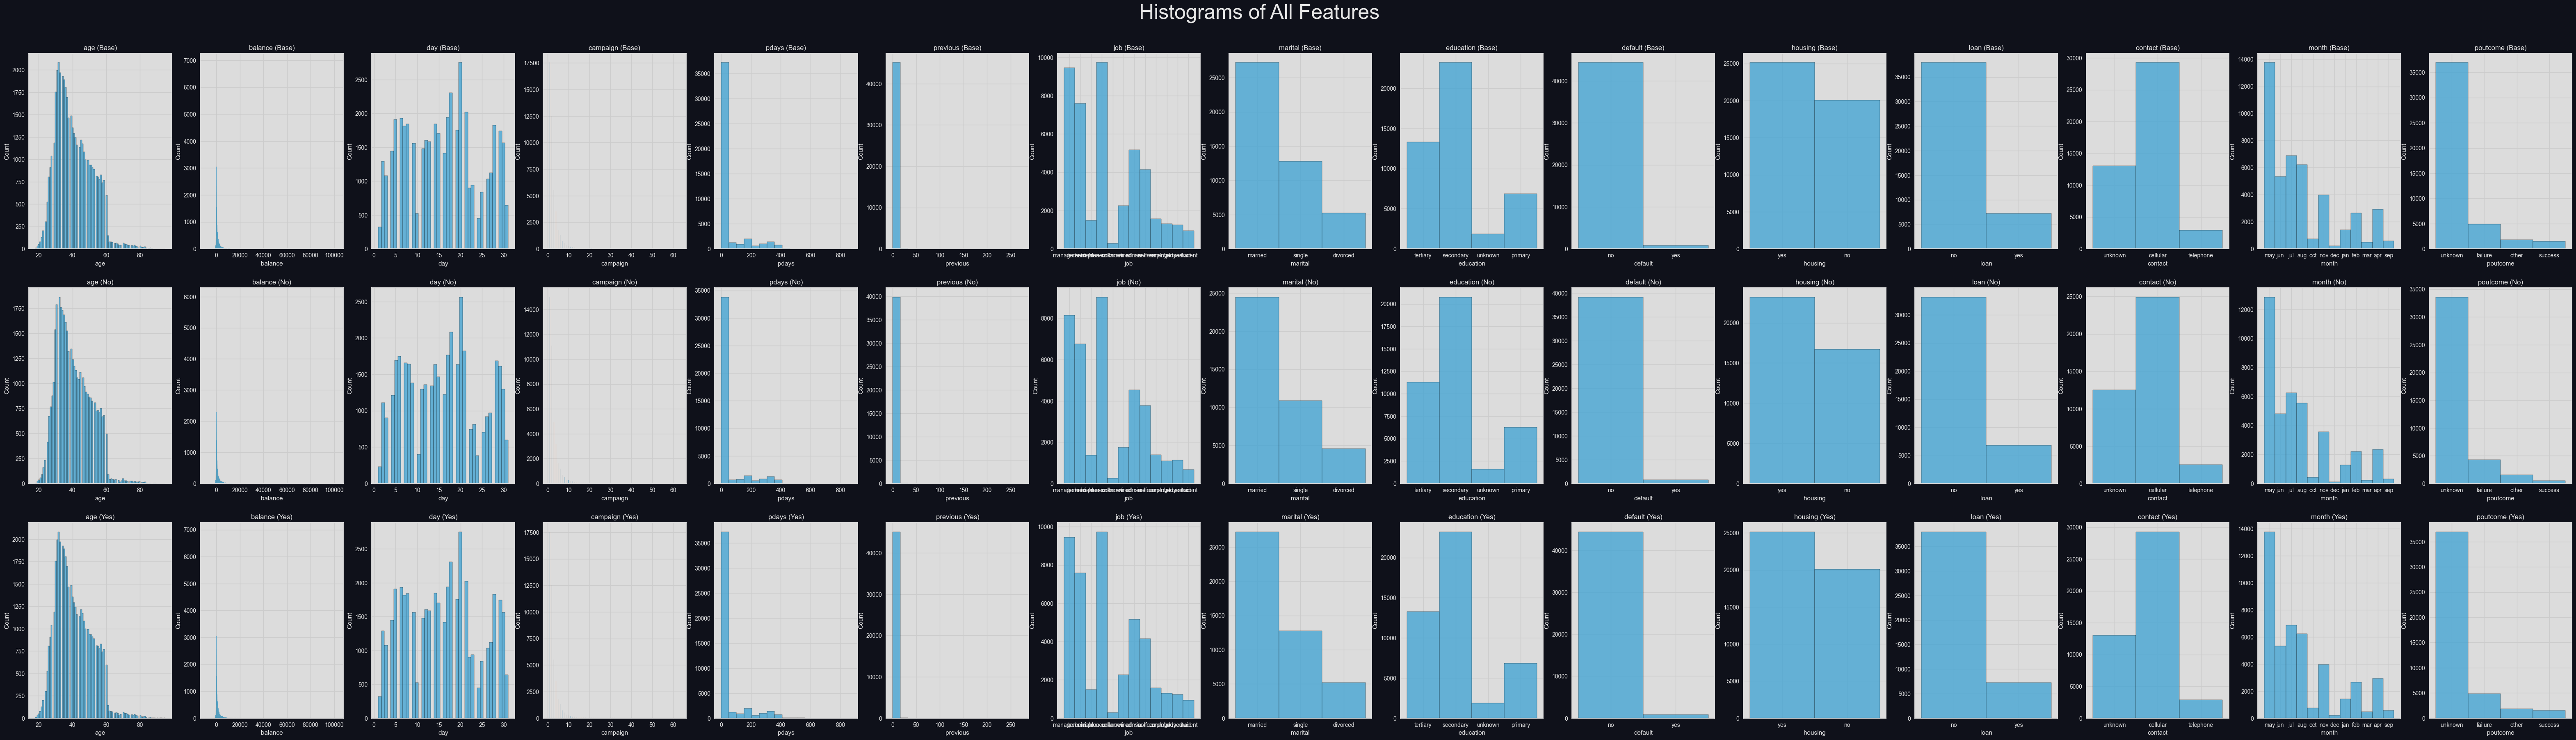

In [56]:
AllHists, axes = plt.subplots(3, 15, figsize=(80, 20))
for idx, col in enumerate(df.columns):
    if col != 'y':
        sns.histplot(ax = axes[0, idx],
                     data = df,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[0, idx].set_title(col + " (Base)")
for idx, col in enumerate(dfNo.columns):
    if col != 'y':
        sns.histplot(ax = axes[1, idx],
                     data = dfNo,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[1, idx].set_title(col + " (No)")
for idx, col in enumerate(dfYes.columns):
    if col != 'y':
        sns.histplot(ax = axes[2, idx],
                     data = df,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[2, idx].set_title(col + " (Yes)")
AllHists.suptitle("Histograms of All Features",
                  fontsize = 36,
                  color = titleColor)
AllHists.subplots_adjust(top=0.92)

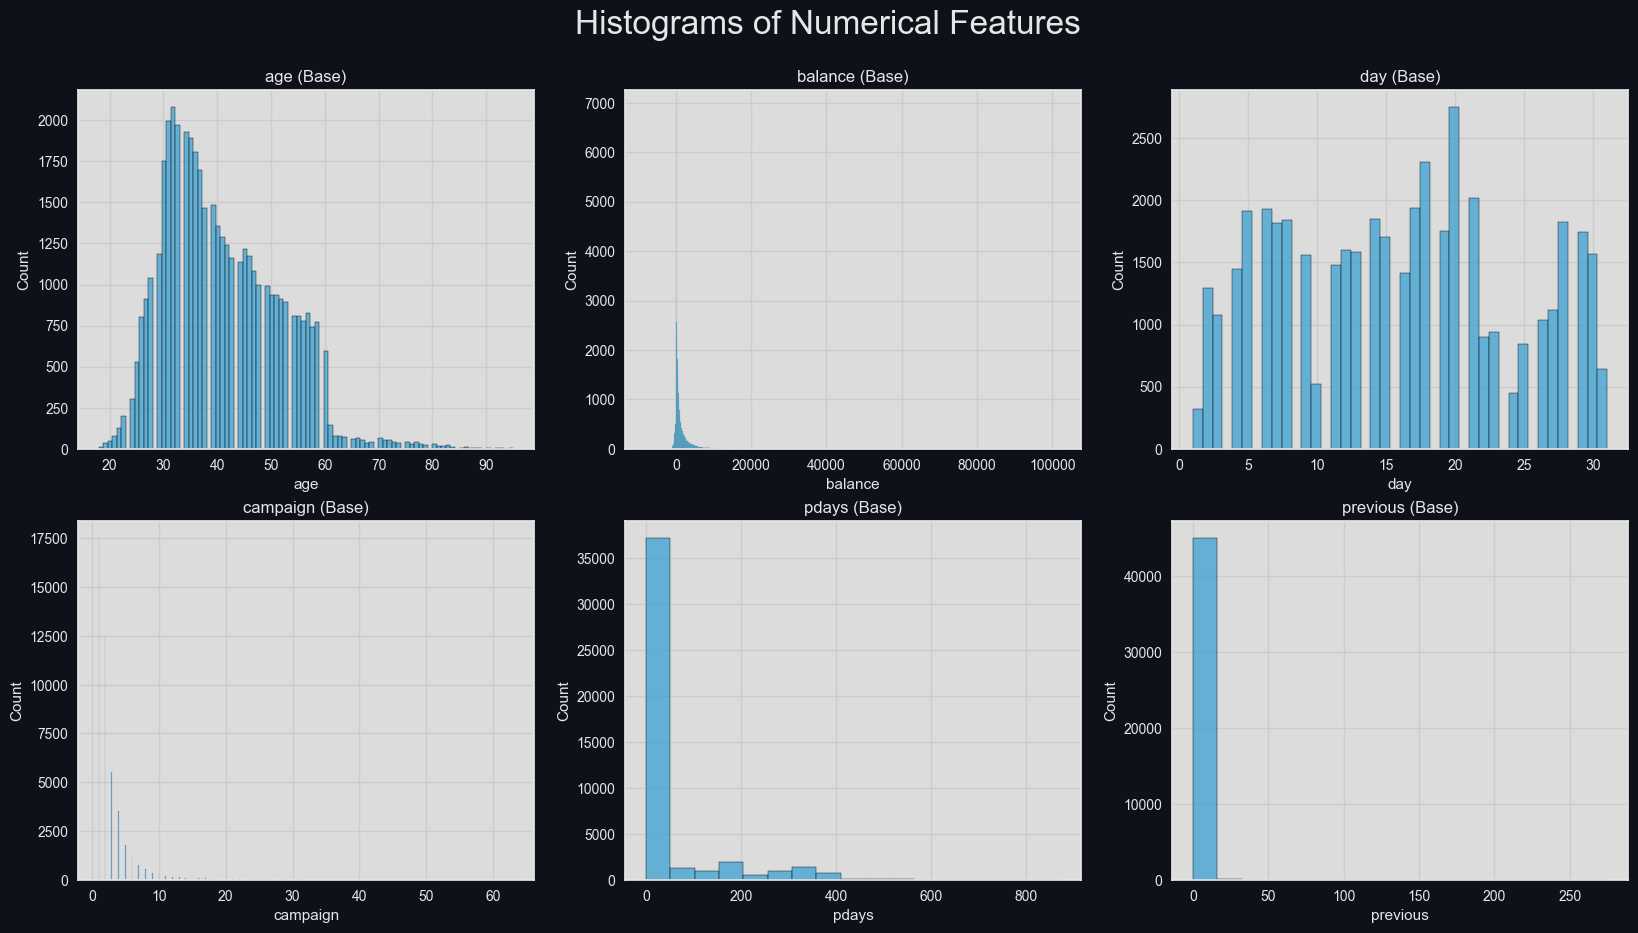

In [57]:
NumHists, axes = plt.subplots(2, 3, figsize=(20, 10))
for idx, col in enumerate(dfNum.columns):
    if col != 'y' and idx < 3:
        sns.histplot(ax = axes[0, idx],
                     data = df,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[0, idx].set_title(col + " (Base)")
    else:
        sns.histplot(ax = axes[1, idx-3],
                     data = df,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[1, idx-3].set_title(col + " (Base)")
NumHists.suptitle("Histograms of Numerical Features",
                  fontsize = 24,
                  color = titleColor)
NumHists.subplots_adjust(top=0.9)


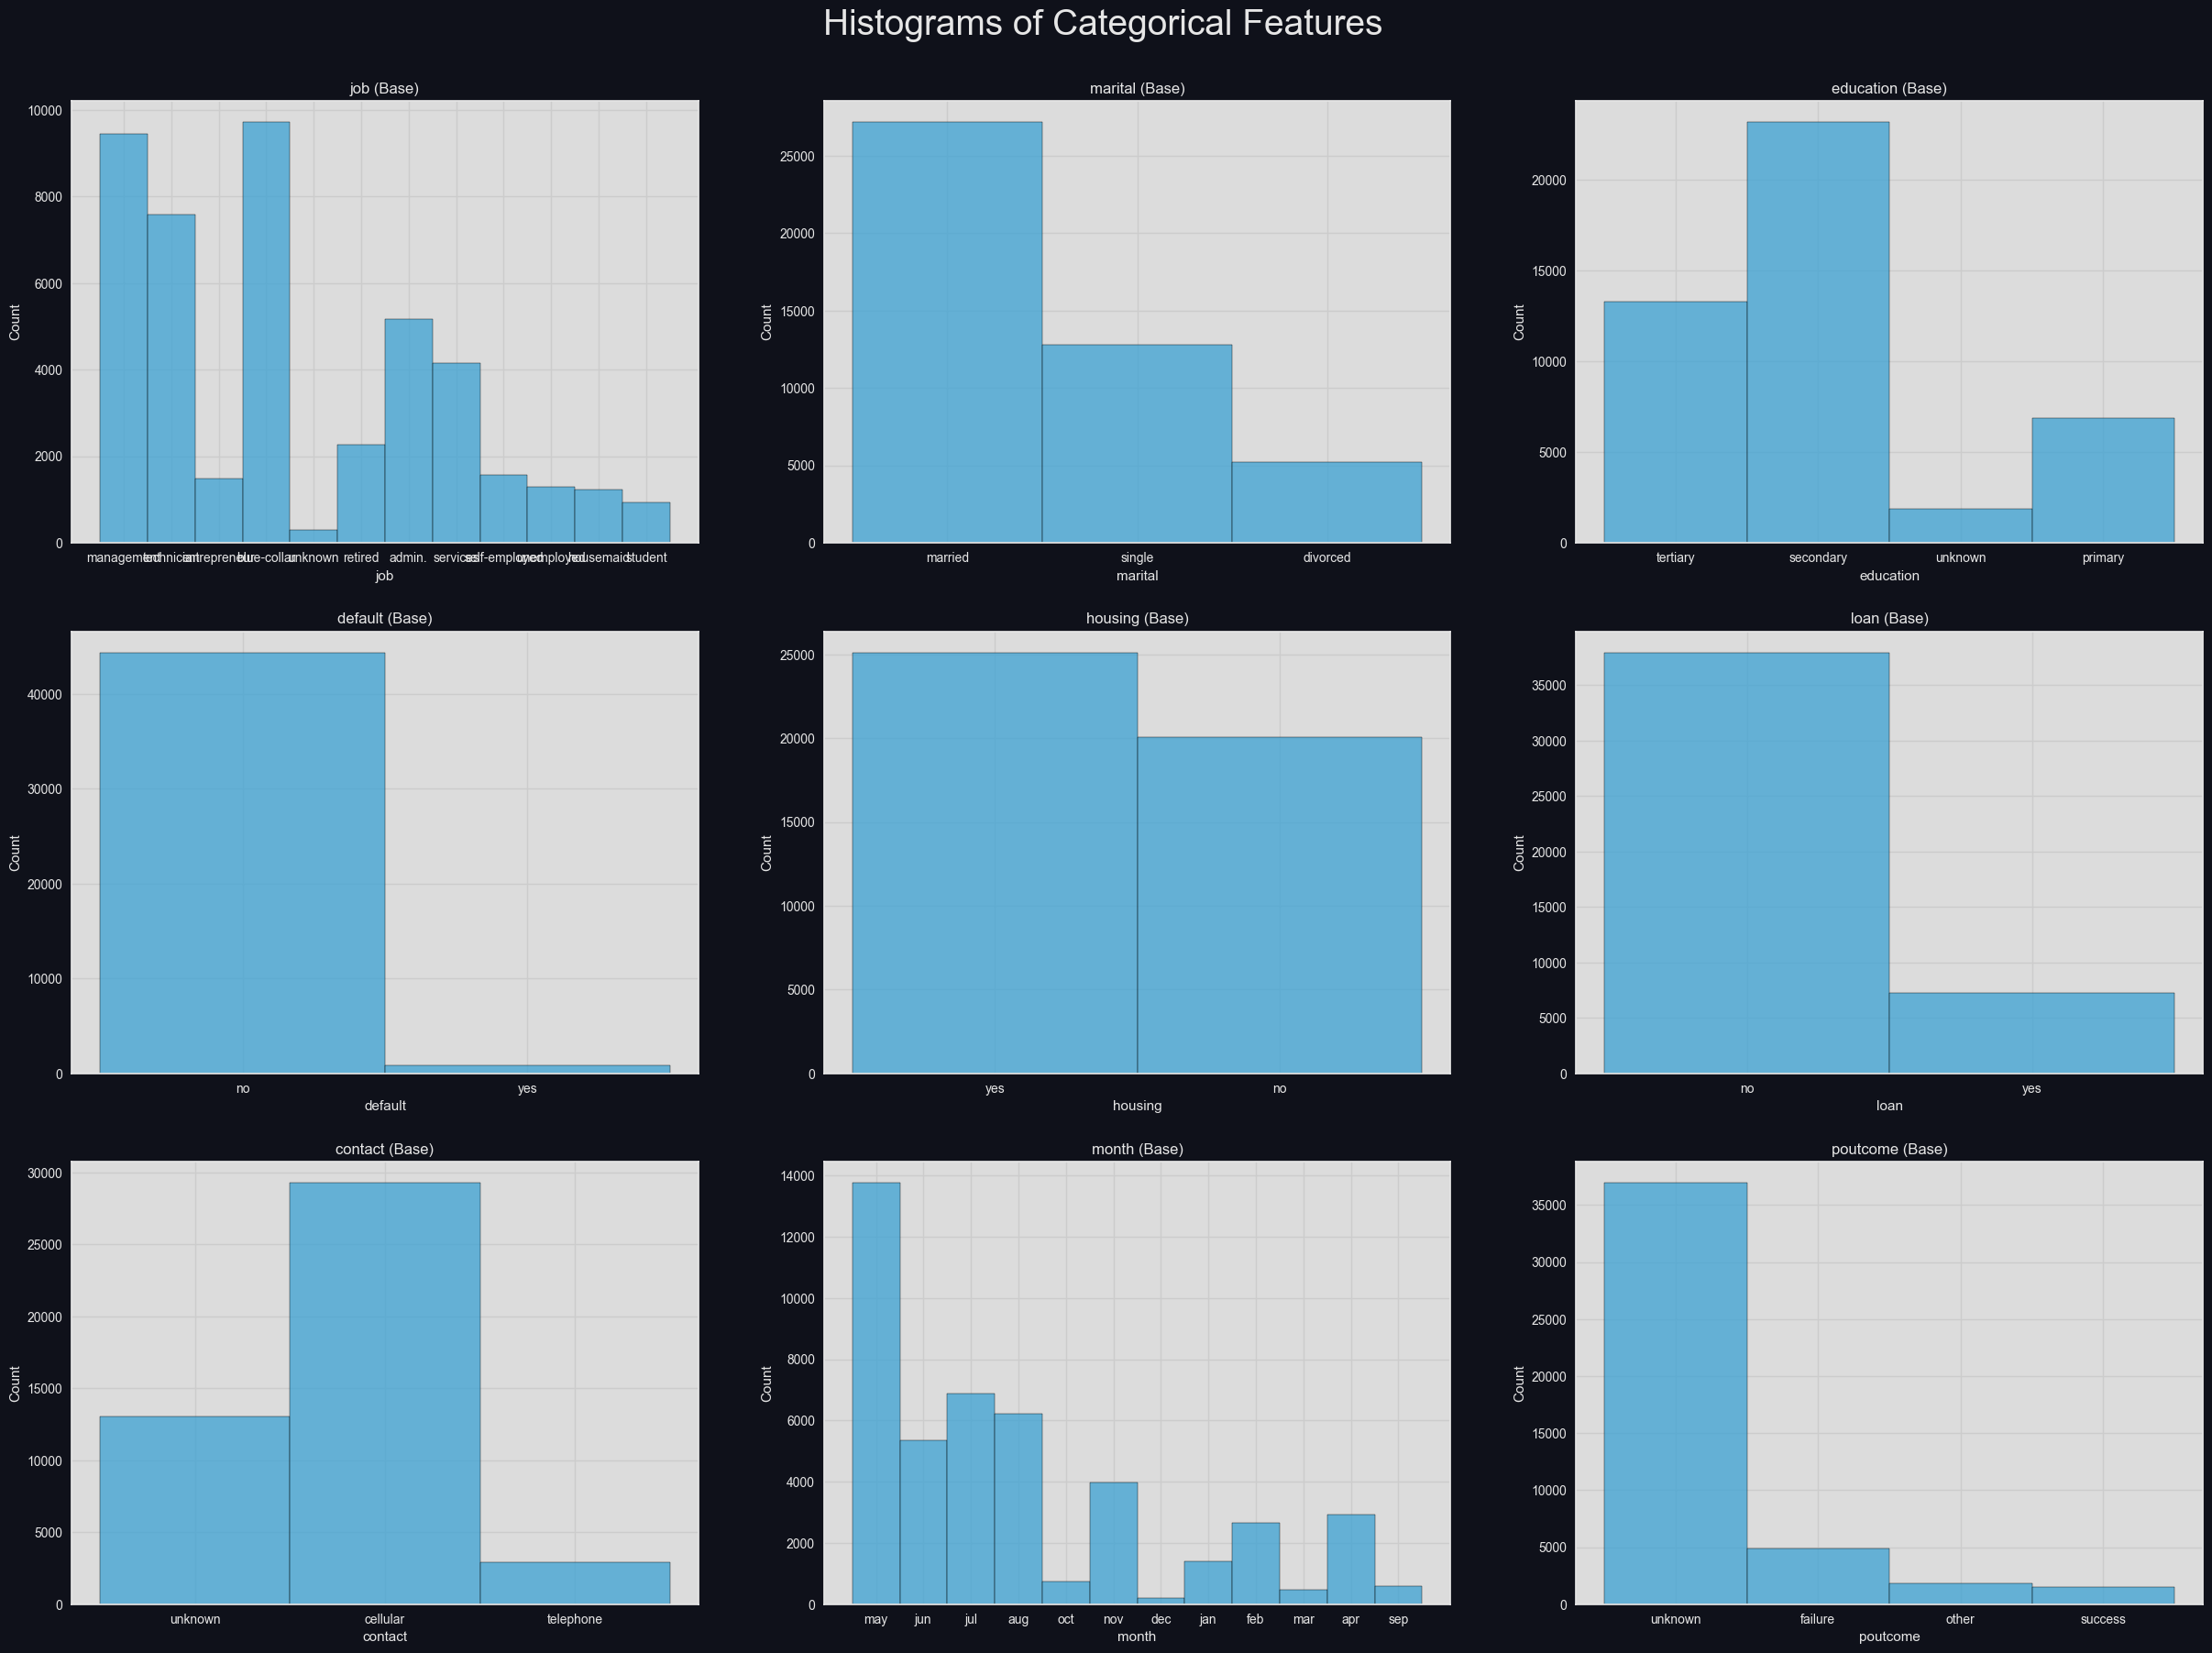

In [58]:
CateHists, axes = plt.subplots(3, 3, figsize=(30, 20))
for idx, col in enumerate(dfCate.columns):
    if col != 'y' and idx < 3:
        sns.histplot(ax = axes[0, idx],
                     data = df,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[0, idx].set_title(col + " (Base)")
    elif col != 'y' and idx < 6:
        sns.histplot(ax = axes[1, idx-3],
                     data = df,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[1, idx-3].set_title(col + " (Base)")
    else:
        sns.histplot(ax = axes[2, idx-6],
                     data = df,
                     x = col,
                     kde = False,
                     color = barColor)
        axes[2, idx-6].set_title(col + " (Base)")
CateHists.suptitle("Histograms of Categorical Features",
                   fontsize = 28,
                   color = titleColor)
CateHists.subplots_adjust(top=0.93)

From here, we will be taking some features that are noticeably different when plotting against output to re-plot it for better visualization.

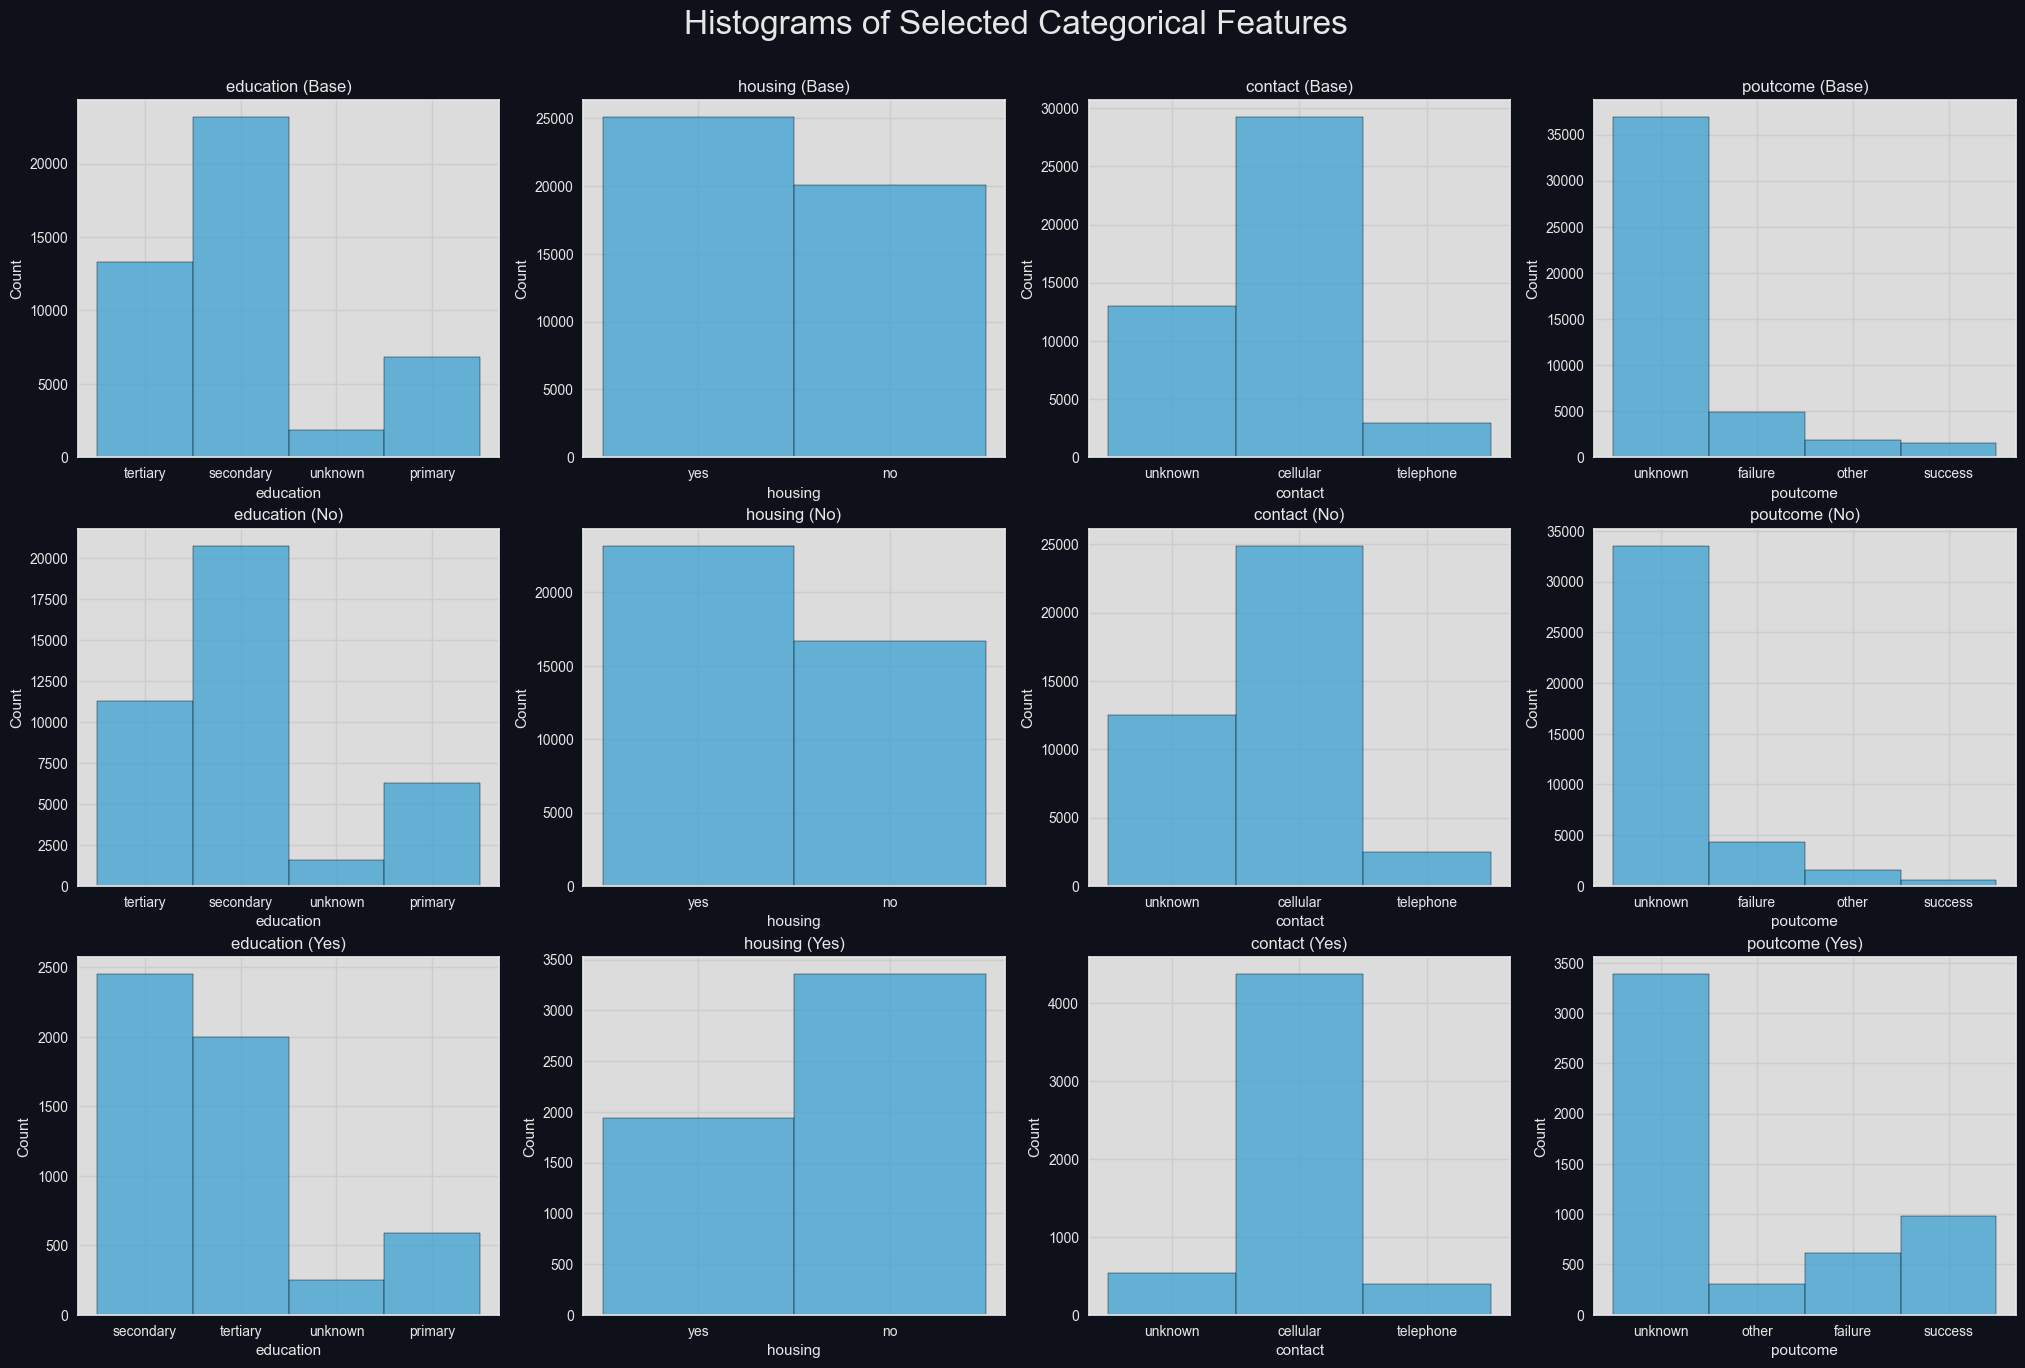

In [59]:
colToPlot = ['education', 'housing', 'contact', 'poutcome']
SelectHists, axes = plt.subplots(3, 4, figsize=(25, 15))
for idx, col in enumerate(colToPlot):
    sns.histplot(ax = axes[0, idx],
                 data = df,
                 x = col,
                 kde = False,
                 color = barColor)
    axes[0, idx].set_title(col + " (Base)")
    sns.histplot(ax = axes[1, idx],
                 data = dfNo,
                 x = col,
                 kde = False,
                 color = barColor)
    axes[1, idx].set_title(col + " (No)")
    sns.histplot(ax = axes[2, idx],
                 data = dfYes,
                 x = col,
                 kde = False,
                 color = barColor)
    axes[2, idx].set_title(col + " (Yes)")
SelectHists.suptitle("Histograms of Selected Categorical Features",
                     fontsize = 24,
                     color = titleColor)
SelectHists.subplots_adjust(top=0.92)


In [60]:
df_vis = df.copy()
df_vis.columns
df_vis['month'] = pd.Categorical(df_vis['month'],['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

<AxesSubplot:xlabel='month', ylabel='Count'>

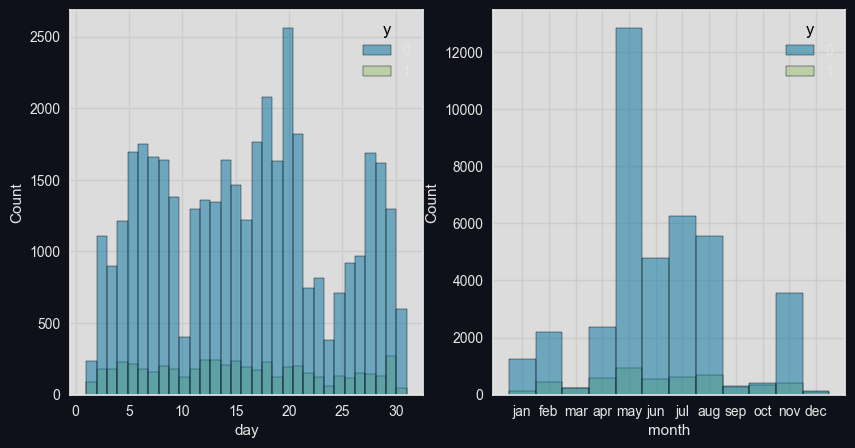

In [62]:
dayPlot, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data = df_vis, 
            x = 'day', 
            hue = 'y',
            bins=31,
            ax=axes[0])
sns.histplot(data = df_vis, 
            x = 'month', 
            hue = 'y',
            ax=axes[1])

<AxesSubplot:xlabel='loan', ylabel='Count'>

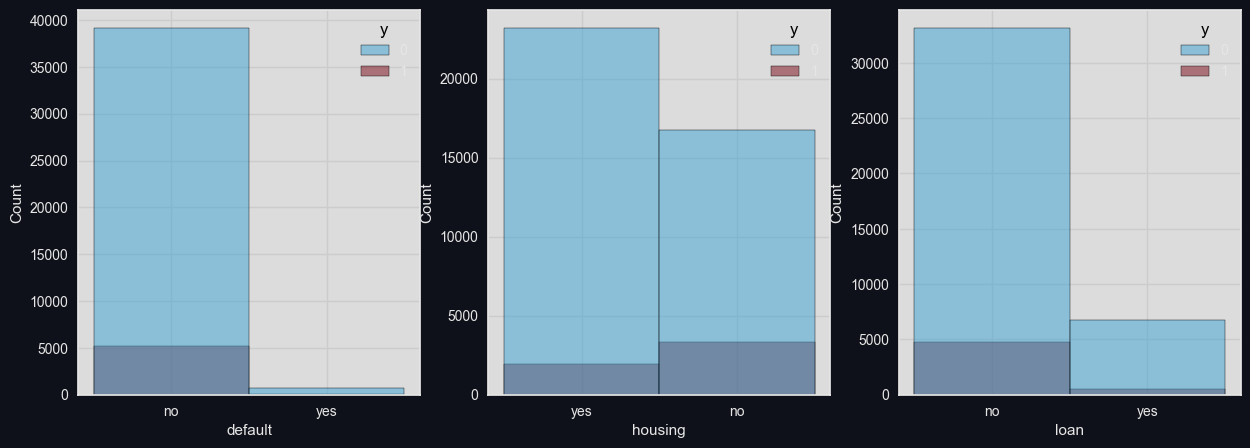

In [80]:
MoneyPlot, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data = df_vis, 
            x = 'default', 
            hue = 'y',
            palette = snsPalette,
            ax=axes[0])
sns.histplot(data = df_vis, 
            x = 'housing', 
            hue = 'y',
            palette = snsPalette,
            ax=axes[1])
sns.histplot(data = df_vis, 
            x = 'loan', 
            hue = 'y',
            palette = snsPalette,
            ax=axes[2])

In [64]:
age_group = pd.cut(df_vis['age'], [10, 20, 30, 40, 50, 60, 70, 80])
df_vis['age'] = age_group
sum_group = df_vis[['balance','age']].groupby('age').sum()
mean_group  = df_vis[['balance','age']].groupby('age').mean()

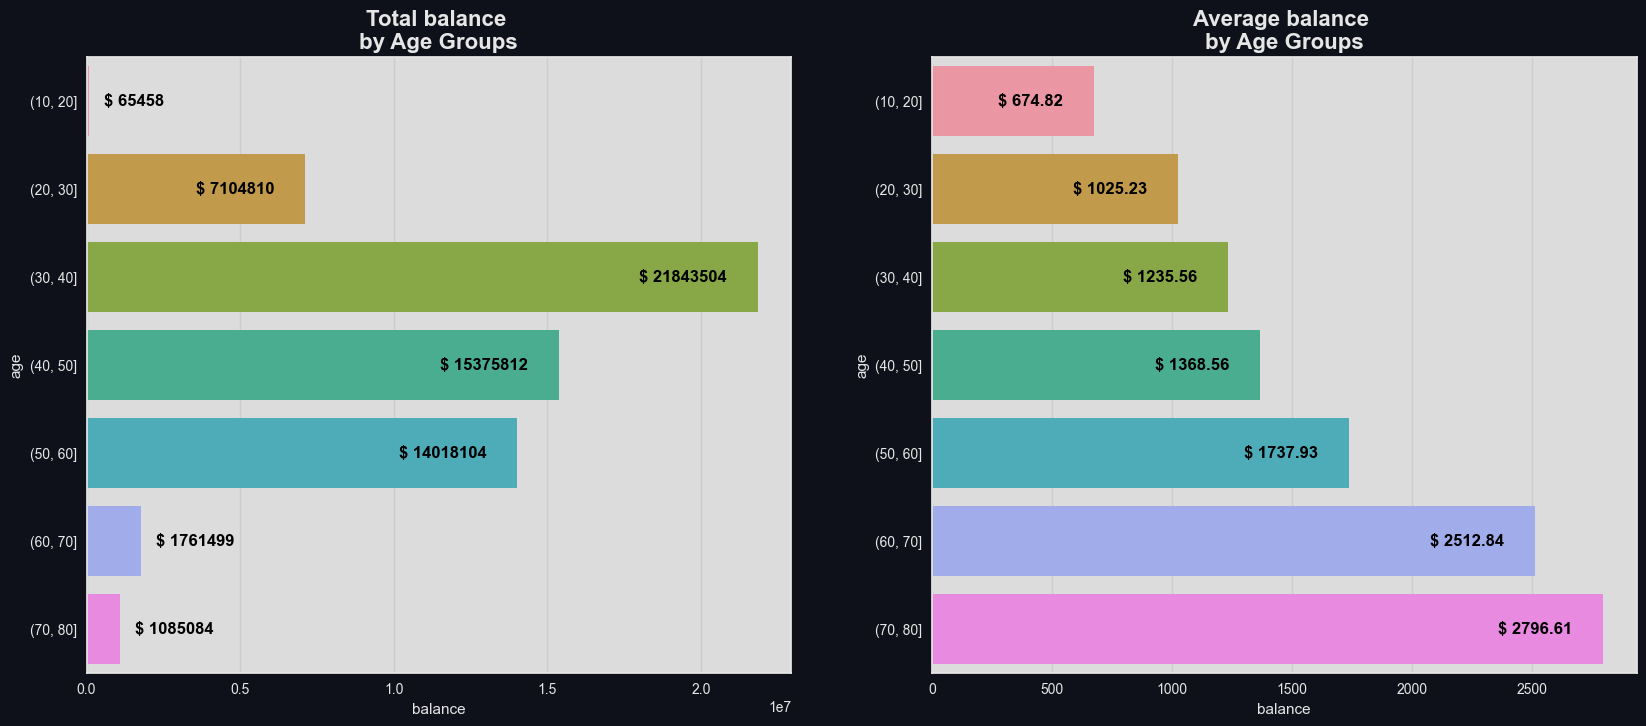

In [78]:
ageGroupPlot, axes = plt.subplots(1, 2, figsize=(20, 8))
axes = axes.flatten()

sns.barplot(x=sum_group['balance'], y=sum_group.index, ci=None, orient='h', ax=axes[0])
axes[0].set_title('Total balance \nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(sum_group['balance']):
    if i in [1, 2, 3, 4]:
        axes[0].text(v-1000000, i, '$ {}'.format(v), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
    else:
        axes[0].text(v+500000, i, '$ {}'.format(v), horizontalalignment='left', verticalalignment='center', weight='bold', color='black', fontsize=12)

sns.barplot(x=mean_group['balance'], y=mean_group.index, ci=None, orient='h', ax=axes[1])
axes[1].set_title('Average balance \nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(mean_group['balance']):
    axes[1].text(v-130, i, '$ {}'.format(round(v,2)), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)

We can see that these features have different charts when plotting against each output. Features plotted against output 'yes' have different bar charts compared to features plotted against all output data while features plotted against output 'no' has the same bar charts.

|Feature Names|Information|
|-|-|
|education|The client with 'secondary' education level has more chance to subscribe a term deposit|
|housing|The client with 'no' housing loan has more chance to subscribe a term deposit|
|contact|The client with 'unknown' communication type has more chance not to subscribe a term deposit|
|poutcome|The client with 'success' outcome of the previous marketing campaign has more chance to subscribe a term deposit|

#### **Pairplotting Data Samples**

We will be pairplotting a tenth of the whole dataset to see the distribution of the data.

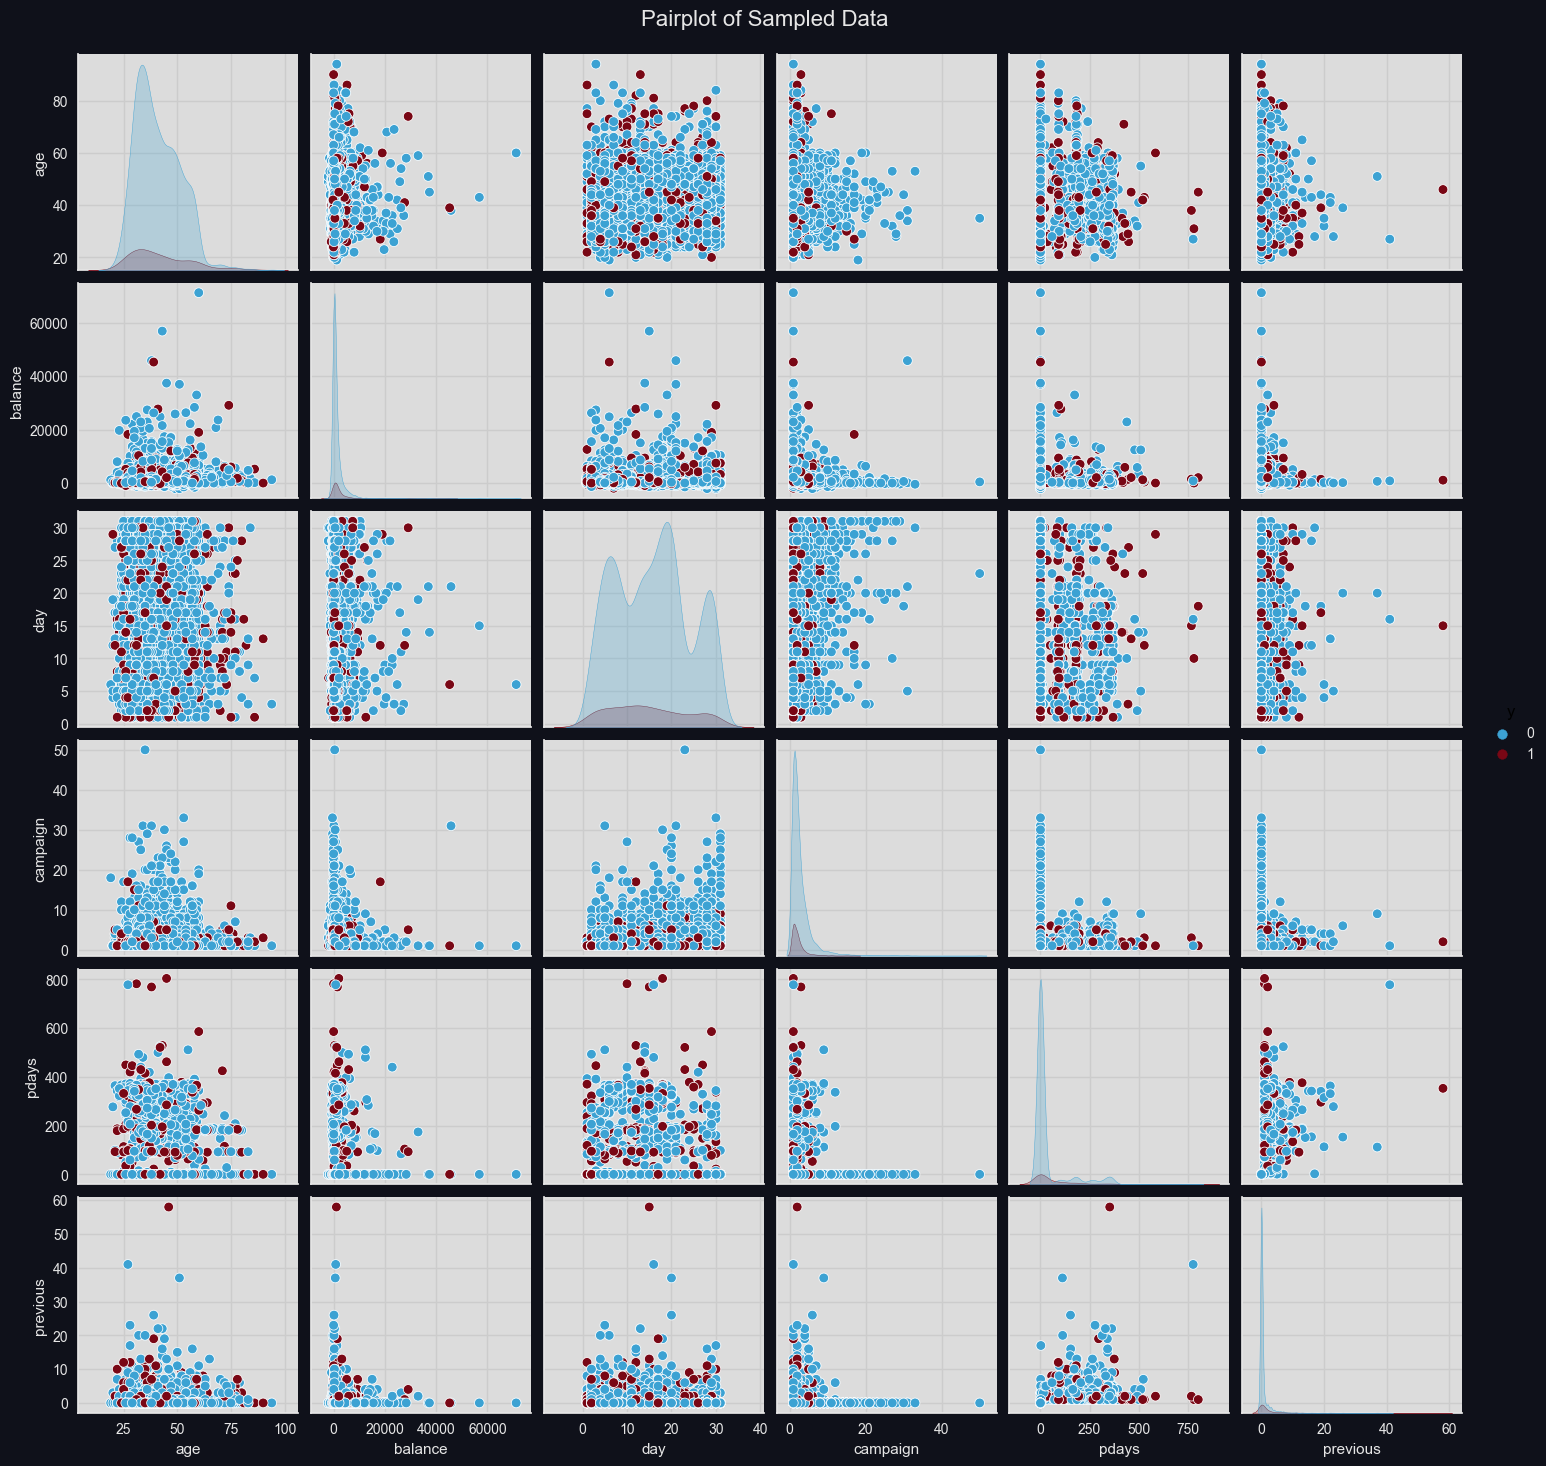

In [79]:
# PairSamp, ax = plt.subplots(1, 1, figsize=(10, 10))
PairSamp = sns.pairplot(data = df.sample(int(df.shape[0]/10), random_state=777),
             diag_kind = 'kde',
             hue = 'y',
             palette = snsPalette)
PairSamp.fig.suptitle("Pairplot of Sampled Data",
                      fontsize=16,
                      color=titleColor)
PairSamp.fig.subplots_adjust(top=0.95)
plt.show(PairSamp)

From the pairplot, we can see that the variance between features are quite low and the variance within features are quite high.

#### **Check for Outliers**

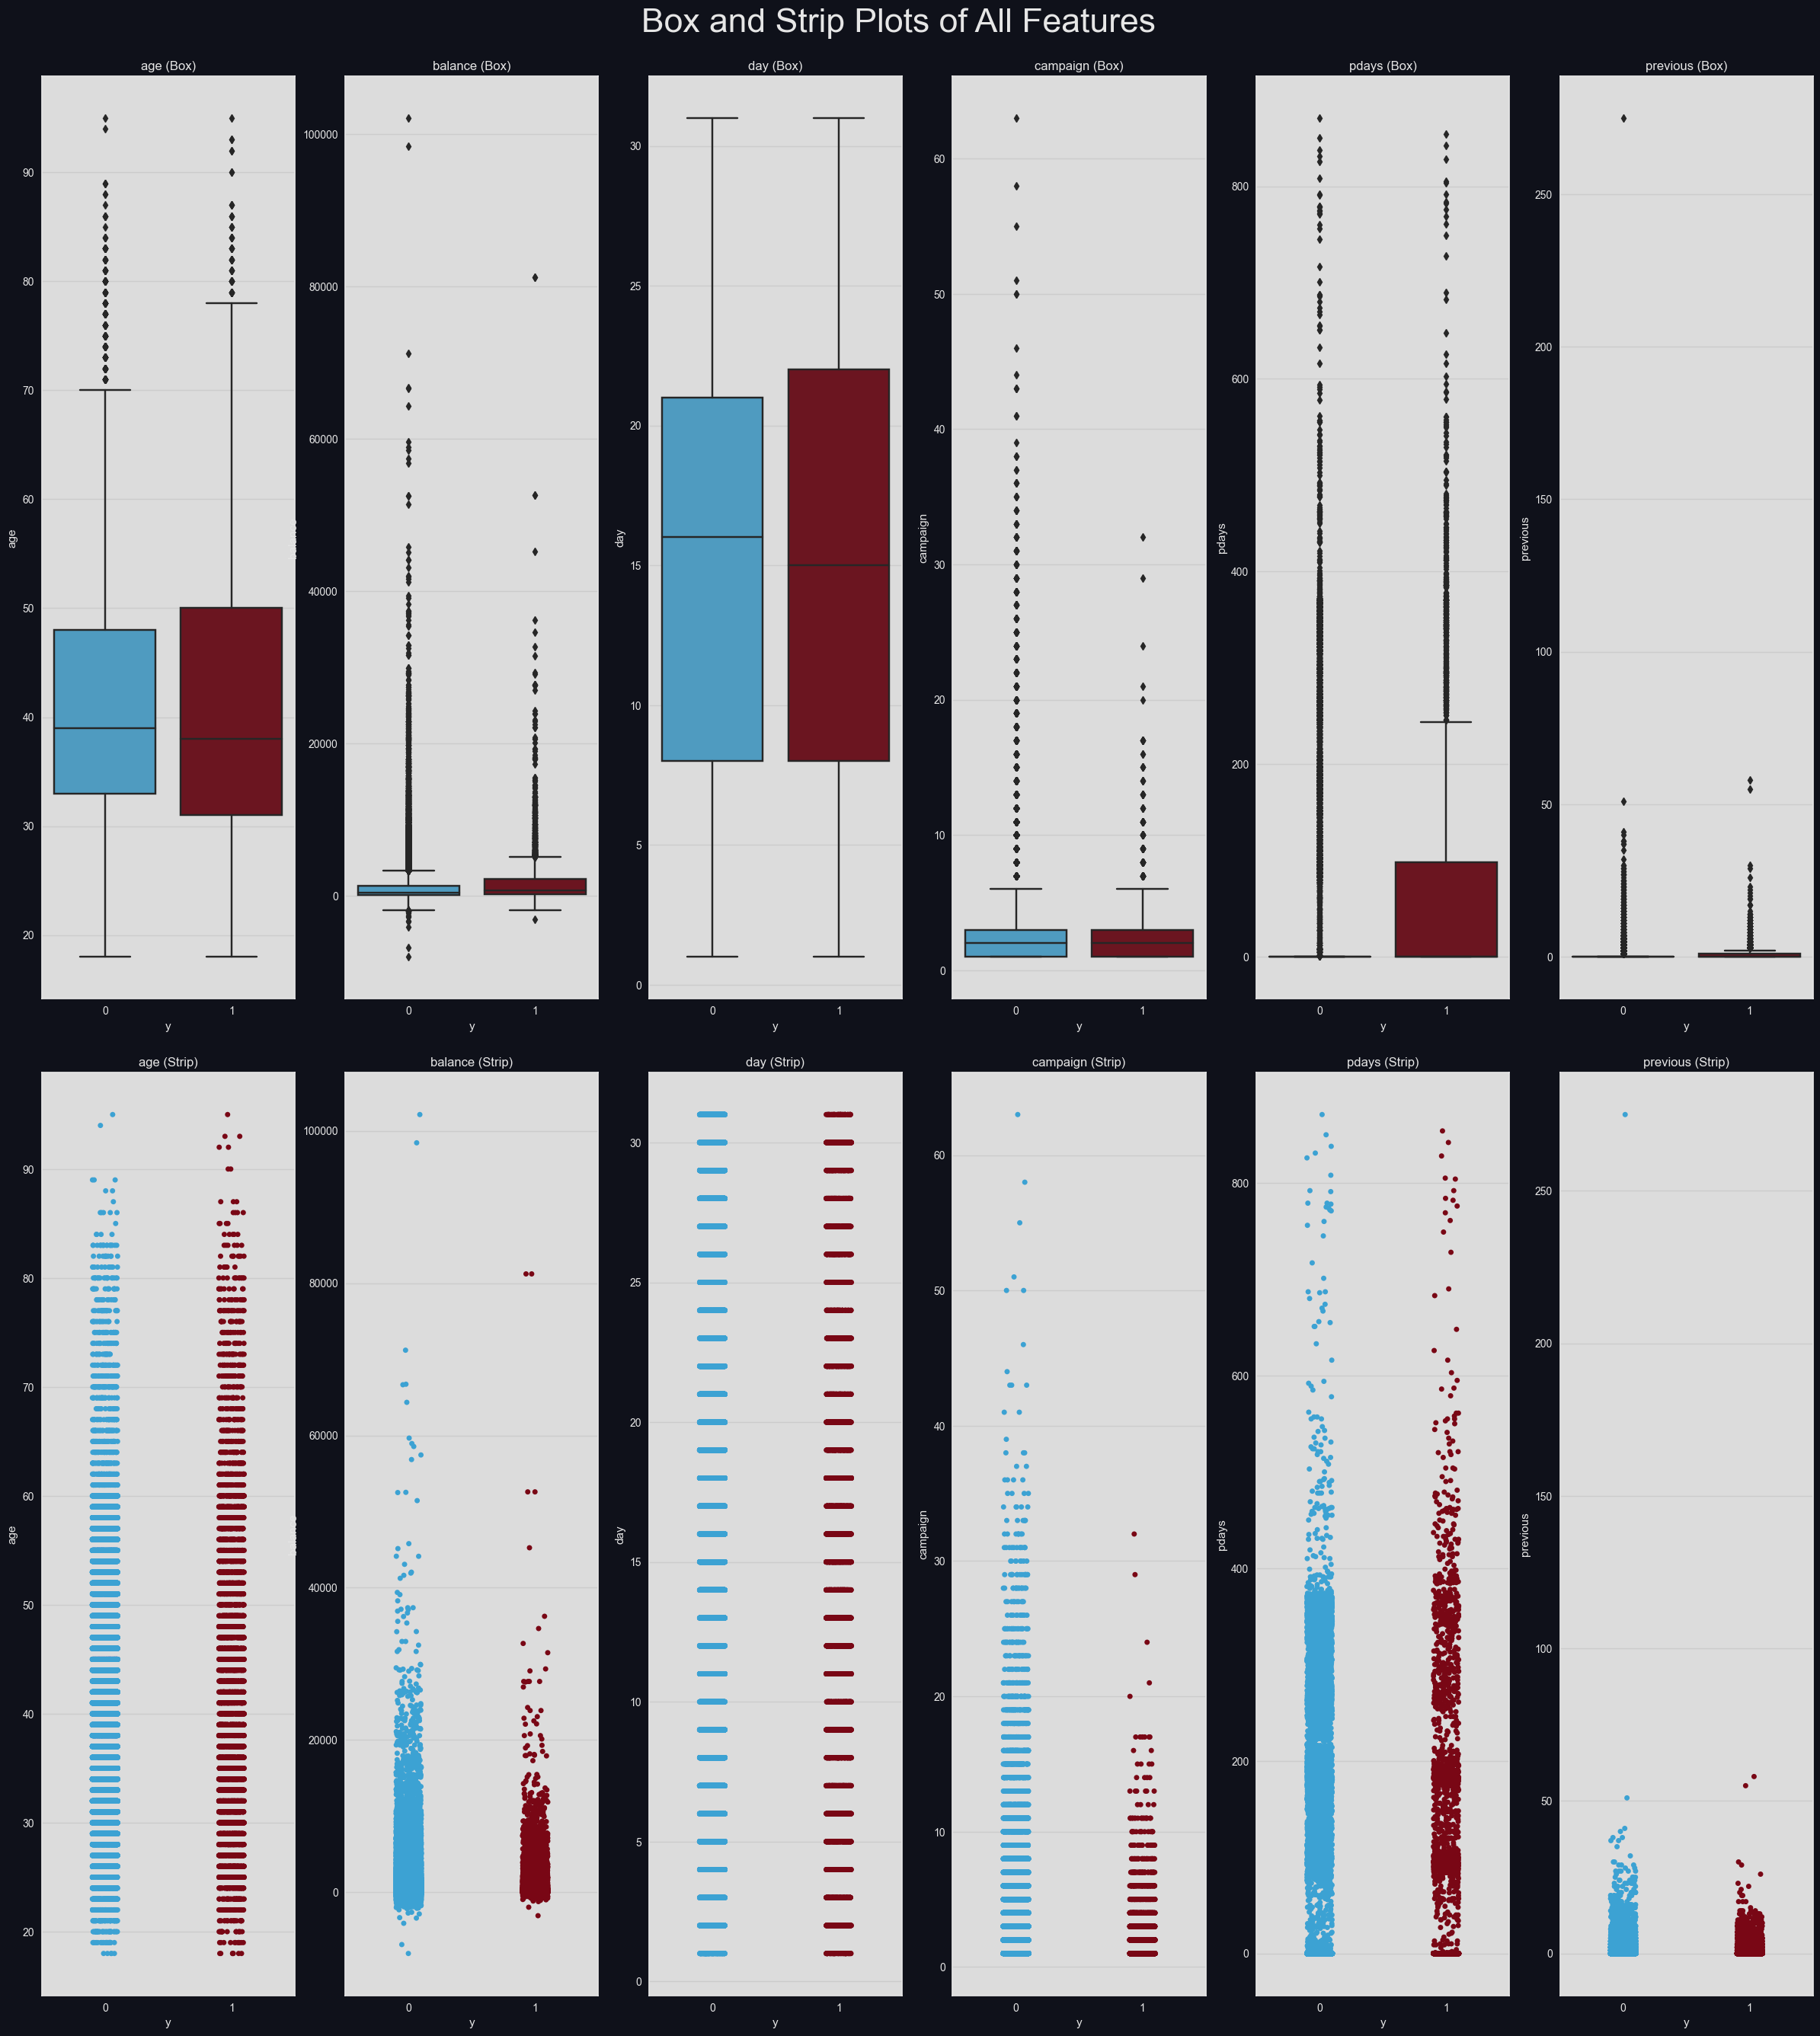

In [81]:
BoxStrip, axes = plt.subplots(2, 6, figsize=(30, 30))
for idx, col in enumerate(dfNum.columns):
    if col != 'y':
        sns.boxplot(ax = axes[0, idx],
                    data = df,
                    x = 'y',
                    y = col,
                    palette = snsPalette)
        axes[0, idx].set_title(col + " (Box)")
        sns.stripplot(ax = axes[1, idx],
                      data = df,
                      x = 'y',
                      y = col,
                      palette = snsPalette)
        axes[1, idx].set_title(col + " (Strip)")
BoxStrip.suptitle("Box and Strip Plots of All Features",
                  fontsize = 32,
                  color = titleColor)
BoxStrip.subplots_adjust(top=0.95, hspace=0.08)
plt.show(BoxStrip)

From the plot above, outliers can be seen in the following features:
- balance
- campaign
- previous

We will remove the outliers at the start of data preprocessing.

### **Data Exploration's Conclusion**

From the overall report,

Plotting Histogram of Numerical Features:

|Feature Names|Distribution|
|-|-|
|age|Right-skewed|
|balance|Right-skewed|
|day|Uniform|
|campaign|Right-skewed|
|pdays|Right-skewed|
|previous|Right-skewed|

Plotting Values Count of Categorical Features:

|Feature Names|What we got|
|-|-|
|job|Most common jobs are 'blue-collar', 'management' and 'technician' (59.2% in total).|
|marital|60.2% of this data are 'Married', 28.3% are 'Single' and the rest are 'Divorced'|
|education|Mostly 'secondary' (51.3%) followed by 'tertiary' (29.4%), 'primary' (15.2%) and 'unknown' (4.1%)|
|default|Mostly 'false' (98.2%)|
|housing|55.6% are 'true' and the rest are 'false'|
|loan|Mostly 'false' (84%)|
|contact|Mostly 'cellular' (64.8%) followed by 'unknown' (28.8%) and 'telephone' (6.4%)|
|month|Mostly 'may' (30.4%)|
|poutcome|Mostly 'unknown' (81.7%) followed by 'failure' (10.8%), 'other' (4.1%) and 'success' (3.3%)|

Good things of this dataset:

|Good Things|Explanation|
|-|-|
|Filled Data in Numerical Features|There are no missing data (NaN) or unknown in numerical features of this dataset.|

Bad things of this dataset:

|Bad Things|Explanation|
|-|-|
|Data Explanation|Most features come with little to no explanation or bad explanation.|
|Data Distribution|There are no normal distributed data. Almost all of them are right-skewed.|
|Data Variation|As we can see when pairplotting, variance between features are quite low and variance within class are quite high in some feature, which means that data variation is very bad.|
|Correlation|There are a lot of high correlation between features.|
|'poutcome' Features|This feature's data are mostly 'unknown' (around 81.7%).|
|Output data|The output is imbalanced. ('yes' is 11.7% and 'no' is 88.3%)|
|Unknown Data|Unclear explanation of what unknown data means and there are a lot of them in categorical features.|

**NOTE**: For all 'Unknown' data in categorical features, we assumed 'Unknown' as a type of data because there are quite a lot of 'Unknown' data.

Furthermore, because we are dealing with a dataset from bank, those 'Unknown' data might be undisclosed information of the customers.

<hr>

Since we are going to use clustering algorithms (unsupervised learning), we will drop the output (y) from the dataset.

In [82]:
dfOri = df.copy()
df.drop('y', axis=1, inplace=True)

## **Data Preprocessing**

### **Experiment 1 : Remove Outliers**

#### **Hypothesis**
    
Outliers in features affects model's performance.

We will check outliers by printing out the first and last 30 sorted values of each numerical features.

In [84]:
with open('checkOutliers.txt', 'w') as f:
    for col in dfNum.columns:
        f.write(f'First 30 Sorted of \'{col}\'' + '\n')
        f.write(str(df[col].sort_values().head(30)) + '\n')
        f.write('='*50 + '\n')
        f.write(f'Last 30 Sorted of \'{col}\'' + '\n')
        f.write(str(df[col].sort_values().tail(30)) + '\n')
        f.write('='*50 + '\n')

From the file we generated, we will be removing those instances that seems to be outliers, which includes these indices below:
- age: none
- day: none
- balance: [12909, 15682, 41693, 42558, 43393, 26227, 39989]
- campaign: [5073, 11914, 4330]
- pdays: [45024, 44530, 44698, 44785, 44858, 44837, 44829, 45146]
- previous: [28886, 44089, 38326, 29182]

In [90]:
dropBalance = [12909, 15682, 41693, 42558, 43393, 26227, 39989]
dropCampaign = [5073, 11914, 4330]
droppdays = [45024, 44530, 44698, 44785, 44858, 44837, 44829, 45146]
dropPrevious = [28886, 44089, 38326, 29182]

dropOutliers = dropBalance + dropCampaign + droppdays + dropPrevious
df.drop(dropOutliers, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45173 entries, 0 to 45172
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45173 non-null  int64 
 1   balance    45173 non-null  int64 
 2   day        45173 non-null  int64 
 3   campaign   45173 non-null  int64 
 4   pdays      45173 non-null  int64 
 5   previous   45173 non-null  int64 
 6   job        45173 non-null  object
 7   marital    45173 non-null  object
 8   education  45173 non-null  object
 9   default    45173 non-null  object
 10  housing    45173 non-null  object
 11  loan       45173 non-null  object
 12  contact    45173 non-null  object
 13  month      45173 non-null  object
 14  poutcome   45173 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


After removing outliers, we are left with <u>**45173 instances**</u> (originally 45211 instances).

In [92]:
columnToOnehot = df.select_dtypes(include=['object']).columns
dfOutliers = pd.get_dummies(df, columns=columnToOnehot)
df = dfOutliers.copy()

### **Experiment 2 : Feature Scaling**

#### **Hypothesis**
    
Scaling data affects model's performance.

##### **Feature Scaling**

In [94]:
dfFS = df.copy()

In [95]:
MinMaxScale = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

In [96]:
for idx in dfFS.columns:
    dfFS[idx] = MinMaxScale.fit_transform(dfFS[idx].values.reshape(-1,1))

In [99]:
dfFS.describe()

age       balance           day      campaign         pdays  \
count  45173.000000  45173.000000  45173.000000  45173.000000  45173.000000   
mean       0.297868      0.076447      0.493520      0.035214      0.050563   
std        0.137868      0.041069      0.277426      0.061302      0.122733   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.194805      0.058337      0.233333      0.000000      0.000000   
50%        0.272727      0.063664      0.500000      0.020000      0.000000   
75%        0.389610      0.077496      0.666667      0.040000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           previous    job_admin.  job_blue-collar  job_entrepreneur  \
count  45173.000000  45173.000000     45173.000000      45173.000000   
mean       0.013919      0.114449         0.215306          0.032918   
std        0.045287      0.318359         0.411039          0.178424   
min        0.000000      0.000000         0.000000          0.000000   
25%        0.000000      0.000000         0.000000          0.000000   
50%        0.000000      0.000000         0.000000          0.000000   
75%        0.000000      0.000000         0.000000          0.000000   
max        1.000000      1.000000         1.000000          1.000000   

       job_housemaid  ...     month_jun     month_mar     month_may  \
count   45173.000000  ...  45173.000000  45173.000000  45173.000000   
mean        0.027428  ...      0.118190      0.010559      0.304629   
std         0.163328  ...      0.322837      0.102216      0.460255   
min         0.000000  ...      0.000000      0.000000      0.000000   
25%         0.000000  ...      0.000000      0.000000      0.000000   
50%         0.000000  ...      0.000000      0.000000      0.000000   
75%         0.000000  ...      0.000000      0.000000      1.000000   
max         1.000000  ...      1.000000      1.000000      1.000000   

          month_nov     month_oct     month_sep  poutcome_failure  \
count  45173.000000  45173.000000  45173.000000      45173.000000   
mean       0.087840      0.016293      0.012707          0.108317   
std        0.283065      0.126601      0.112007          0.310784   
min        0.000000      0.000000      0.000000          0.000000   
25%        0.000000      0.000000      0.000000          0.000000   
50%        0.000000      0.000000      0.000000          0.000000   
75%        0.000000      0.000000      0.000000          0.000000   
max        1.000000      1.000000      1.000000          1.000000   

       poutcome_other  poutcome_success  poutcome_unknown  
count    45173.000000      45173.000000      45173.000000  
mean         0.040622          0.033427          0.817634  
std          0.197414          0.179751          0.386150  
min          0.000000          0.000000          0.000000  
25%          0.000000          0.000000          1.000000  
50%          0.000000          0.000000          1.000000  
75%          0.000000          0.000000          1.000000  
max          1.000000          1.000000          1.000000  

[8 rows x 50 columns]

In [100]:
df = dfFS.copy()

### **Experiment 3 : Feature Extraction**

#### **Hypothesis**

Too many features affects model's performance.

#### **Feature Extraction**

In [101]:
dfFE = df.copy()

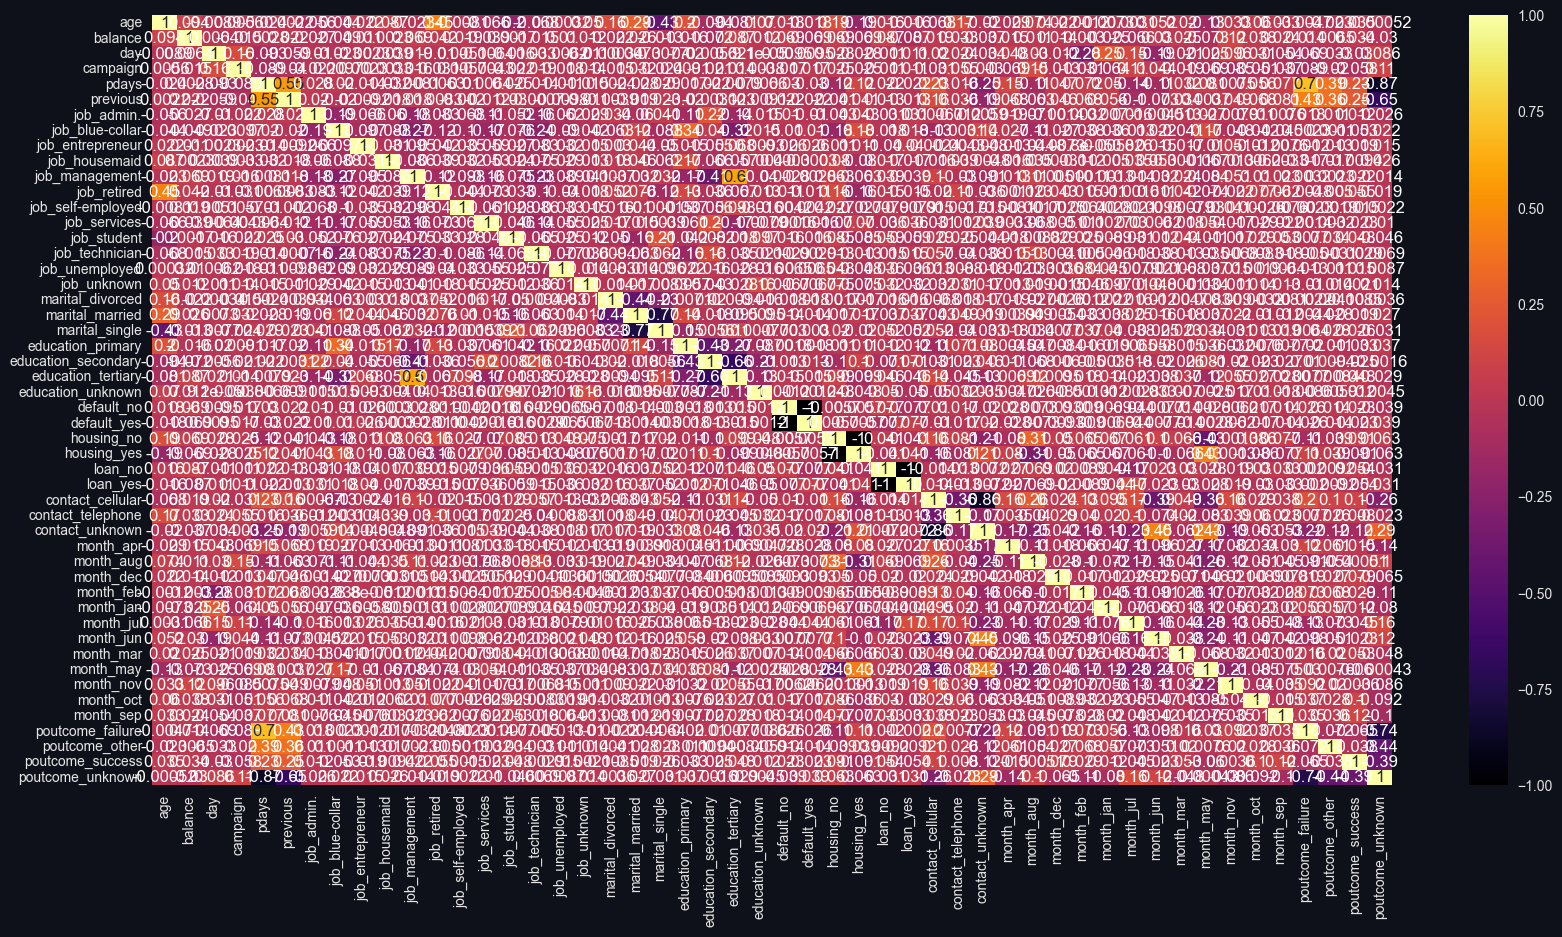

In [102]:
checkCorrFF(dfFE)

We will be using Principal Component Analysis (PCA) to extract features.

#### **Principal Component Analysis (PCA)**

In [103]:
def plot3Dscatter(df, target, imgName = None, title = None):
    X = df.drop([target], axis=1)
    ax = [X.columns[0], X.columns[1], X.columns[2]]
    X = X.to_numpy()
    y = df[target].to_numpy()
    fig = px.scatter_3d(
        X, x=0, y=1, z=2, color=y,
        labels = {
        str(i): f"{var}"
        for i, var in enumerate(ax)
        },
        title = title,
        width=800, height=800
    )
    if imgName != None:
        fig.write_image("img/"+imgName+".png") 
    fig.show()

[0.15305474 0.25147416 0.3475759  0.43607545 0.49739298 0.55094899
 0.59718061 0.63447916 0.66891702 0.70228251 0.73157774 0.75760223
 0.77992698 0.80135282 0.82173838 0.84059563 0.85768987 0.87274445
 0.88579165 0.89786783 0.90912846 0.92017508 0.92998085 0.93892572
 0.94674014 0.95435186 0.96167698 0.96800068 0.97389698 0.97965929
 0.98418775 0.98798939 0.9908864  0.99329738 0.99547375 0.99691668
 0.99801255 0.99874413 0.99940033 0.99974893 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
(50,)
20


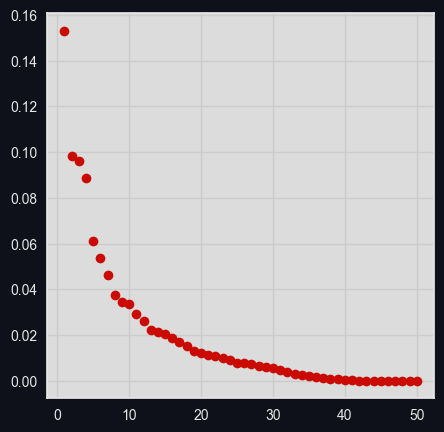

In [106]:
pca = PCA(n_components = len(dfFE.columns))           
pca_data = pca.fit_transform(dfFE)          

print(pca.explained_variance_ratio_.cumsum())
print(pca.explained_variance_ratio_.cumsum().shape)
print(np.where(pca.explained_variance_ratio_.cumsum() > 0.90)[0][0])

plt.figure(figsize=(5,5))
for i in range(0, len(pca.explained_variance_ratio_)):
    plt.plot(i+1, pca.explained_variance_ratio_[i], 'ro')
plt.show()

In [107]:
pca = PCA(n_components = 20) # ~90% of Data Representation
x_pca = pca.fit_transform(dfFS)
col = [
    str(f'PC{i+1}') for i in range(0, len(pca.explained_variance_ratio_))
    ]

dfPCA = pd.DataFrame(x_pca, columns = col)
dfPCA.describe()

PC1           PC2           PC3           PC4           PC5  \
count  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04   
mean  -7.046757e-17 -2.265029e-17  7.550097e-17  9.123033e-17  4.530058e-17   
std    8.376546e-01  6.717102e-01  6.637541e-01  6.369599e-01  5.301929e-01   
min   -1.560922e+00 -1.567190e+00 -1.459113e+00 -1.420284e+00 -1.030394e+00   
25%   -7.118339e-01 -4.529146e-01 -5.961603e-01 -5.093179e-01 -3.181612e-01   
50%    5.237319e-02 -3.848313e-02  7.119680e-02 -3.356850e-02 -1.368191e-01   
75%    6.375925e-01  4.663980e-01  4.518530e-01  5.288073e-01  8.161869e-02   
max    1.593303e+00  1.982856e+00  1.682300e+00  1.721139e+00  1.722805e+00   

                PC6           PC7           PC8           PC9          PC10  \
count  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04   
mean   2.107735e-16 -6.543417e-17  4.278388e-17  2.202112e-17 -1.790002e-16   
std    4.955023e-01  4.603744e-01  4.135114e-01  3.973375e-01  3.911022e-01   
min   -8.570207e-01 -1.161173e+00 -1.165326e+00 -8.981386e-01 -7.942563e-01   
25%   -3.791942e-01 -3.079526e-01 -3.421757e-01 -3.024333e-01 -2.215582e-01   
50%   -8.821060e-02 -6.170111e-02 -2.338068e-02 -7.748369e-02 -9.200935e-02   
75%    2.609090e-01  3.012158e-01  3.269625e-01  2.246277e-01  4.548696e-02   
max    1.925105e+00  2.048974e+00  1.237482e+00  1.484107e+00  1.535056e+00   

               PC11          PC12          PC13          PC14          PC15  \
count  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04   
mean  -1.132514e-16 -1.519457e-16 -4.876104e-17  7.550097e-17  7.172592e-17   
std    3.664714e-01  3.454082e-01  3.199146e-01  3.134073e-01  3.057043e-01   
min   -1.241972e+00 -1.252444e+00 -8.648637e-01 -7.759703e-01 -1.072149e+00   
25%   -2.511609e-01 -2.380134e-01 -1.384744e-01 -2.255678e-01 -1.488531e-01   
50%   -4.546134e-04 -1.163989e-02 -2.121061e-02 -4.720324e-02 -3.510834e-03   
75%    2.491807e-01  2.081933e-01  9.433620e-02  1.739638e-01  1.702555e-01   
max    1.422233e+00  1.388781e+00  1.064167e+00  1.459791e+00  1.374359e+00   

               PC16          PC17          PC18          PC19          PC20  
count  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04  4.517300e+04  
mean  -5.347985e-17 -1.388903e-16 -2.579616e-17 -5.033398e-18  1.635854e-17  
std    2.940161e-01  2.799071e-01  2.627022e-01  2.445375e-01  2.352761e-01  
min   -8.253140e-01 -1.032415e+00 -8.185073e-01 -7.174196e-01 -8.147092e-01  
25%   -2.029804e-01 -1.710425e-01 -1.506515e-01 -5.810265e-02 -1.370663e-01  
50%   -3.048714e-02  3.575645e-02 -3.845273e-02 -1.019733e-02 -4.048311e-02  
75%    1.309460e-01  1.710187e-01  7.640530e-02  3.052063e-02  7.133132e-02  
max    1.466288e+00  1.094449e+00  1.175405e+00  1.032548e+00  1.025837e+00

#### **Save to CSV**
We do it so we don't have to run everything again every single time. It takes forever to run! ;-;

In [109]:
dfOutliers.to_csv('dfForVisualization.csv', index=False)
dfPCA.to_csv('dfForModeling.csv', index=False)

## **Modeling**

### **Model 2: Hierarchical Clustering**

In [ ]:
dfHier = pd.read_csv('dfPCA.csv')
x_hier, y_hier = dfHier.drop('y', axis=1), dfHier['y']
dfHier.describe().T

In [ ]:
dend, ax = plt.subplots(1, 1, figsize=(10, 7))
dn1 = dendrogram(linkage(x_hier, method='ward'), ax=ax)

In [ ]:
# Agg_hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
# y_hc = Agg_hc.fit_predict(dfHier.drop('y', axis=1))

In [ ]:
# dfHier['y'] = y_hc
# dfHier.value_counts('y')

In [ ]:
dfBackup = df.copy()

In [ ]:
df = dfBackup.copy()
df['pdays'].value_counts()

In [ ]:
df['pdays'].replace(-1, 0, inplace=True)
df['pdays'].value_counts()

In [ ]:
with open('checkOutlier.txt', 'w') as f:
    for col in dfNum.columns:
        f.write(f'First 30 Sorted of \'{col}\'' + '\n')
        f.write(str(df[col].sort_values().head(30)) + '\n')
        f.write('='*50 + '\n')
        f.write(f'Last 30 Sorted of \'{col}\'' + '\n')
        f.write(str(df[col].sort_values().tail(30)) + '\n')
        f.write('='*50 + '\n')

From the file we generated, we will be removing those instances that seems to be outliers, which includes these indices below:
- age: none
- day: none
- balance: [12909, 15682, 41693, 42558, 43393, 26227, 39989]
- campaign: [5073, 11914, 4330]
- pdays: [45024, 44530, 44698, 44785, 44858, 44837, 44829, 45146]
- previous: [28886, 44089, 38326, 29182]

In [ ]:
dropBalance = [12909, 15682, 41693, 42558, 43393, 26227, 39989]
dropCampaign = [5073, 11914, 4330]
droppdays = [45024, 44530, 44698, 44785, 44858, 44837, 44829, 45146]
dropPrevious = [28886, 44089, 38326, 29182]

dropOutliers = dropBalance + dropCampaign + droppdays + dropPrevious
df.drop(dropOutliers, axis=0, inplace=True)